In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/terrain-recognition/Data Main/val/Rocky/Rocky (20)_13_31.png
/kaggle/input/terrain-recognition/Data Main/val/Rocky/Rocky (15)_6_31.png
/kaggle/input/terrain-recognition/Data Main/val/Rocky/Rocky (16)_6_8.png
/kaggle/input/terrain-recognition/Data Main/val/Rocky/Rocky (13)_14_14.png
/kaggle/input/terrain-recognition/Data Main/val/Rocky/Rocky (8)_17_9.png
/kaggle/input/terrain-recognition/Data Main/val/Rocky/Rocky (6)_1_14.png
/kaggle/input/terrain-recognition/Data Main/val/Rocky/Rocky (8)_1_2.png
/kaggle/input/terrain-recognition/Data Main/val/Rocky/Rocky (1)_4_9.png
/kaggle/input/terrain-recognition/Data Main/val/Rocky/Rocky (14)_17_16.png
/kaggle/input/terrain-recognition/Data Main/val/Rocky/Rocky (15)_16_17.png
/kaggle/input/terrain-recognition/Data Main/val/Rocky/Rocky (20)_1_3.png
/kaggle/input/terrain-recognition/Data Main/val/Rocky/Rocky (20)_12_27.png
/kaggle/input/terrain-recognition/Data Main/val/Rocky/Rocky (6)_1_18.png
/kaggle/input/terrain-recognition/Data Mai

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from transformers import ViTFeatureExtractor, TFAutoModelForImageClassification
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.applications import InceptionV3

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import glob as gb
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import imagehash
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.applications import VGG16
from keras.applications import ResNet101

In [7]:
train_path = '/kaggle/input/terrain-recognition/Data Main/train'
test_path = '/kaggle/input/terrain-recognition/Data Main/test'

In [8]:
from keras.preprocessing.image import ImageDataGenerator
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    fill_mode='nearest'             # Fill mode for new pixels after shifts/rotations
)

In [9]:
size_images = 150
batch_size = 32

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(size_images, size_images),  # Resize images to this size
    batch_size = batch_size,        # Number of images in each batch
    class_mode ='categorical'       # Mode for class labels (categorical for one-hot encoding)
)

Found 31571 images belonging to 4 classes.


In [11]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [12]:
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(size_images, size_images),
    batch_size = batch_size,
    class_mode='categorical')

Found 6769 images belonging to 4 classes.


In [13]:
def Show_Images(target_gen):
    # Get a batch of images and labels
    batch_images, batch_labels = next(target_gen)

    # Get class labels
    class_labels = list(target_gen.class_indices.keys())

    # Display images with labels
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(batch_images),36))):
        plt.subplot(6, 6, n + 1)
        plt.imshow(batch_images[i])
        plt.title(class_labels[np.argmax(batch_labels[i])])  # Display the class label
        plt.axis('off')
    plt.show()

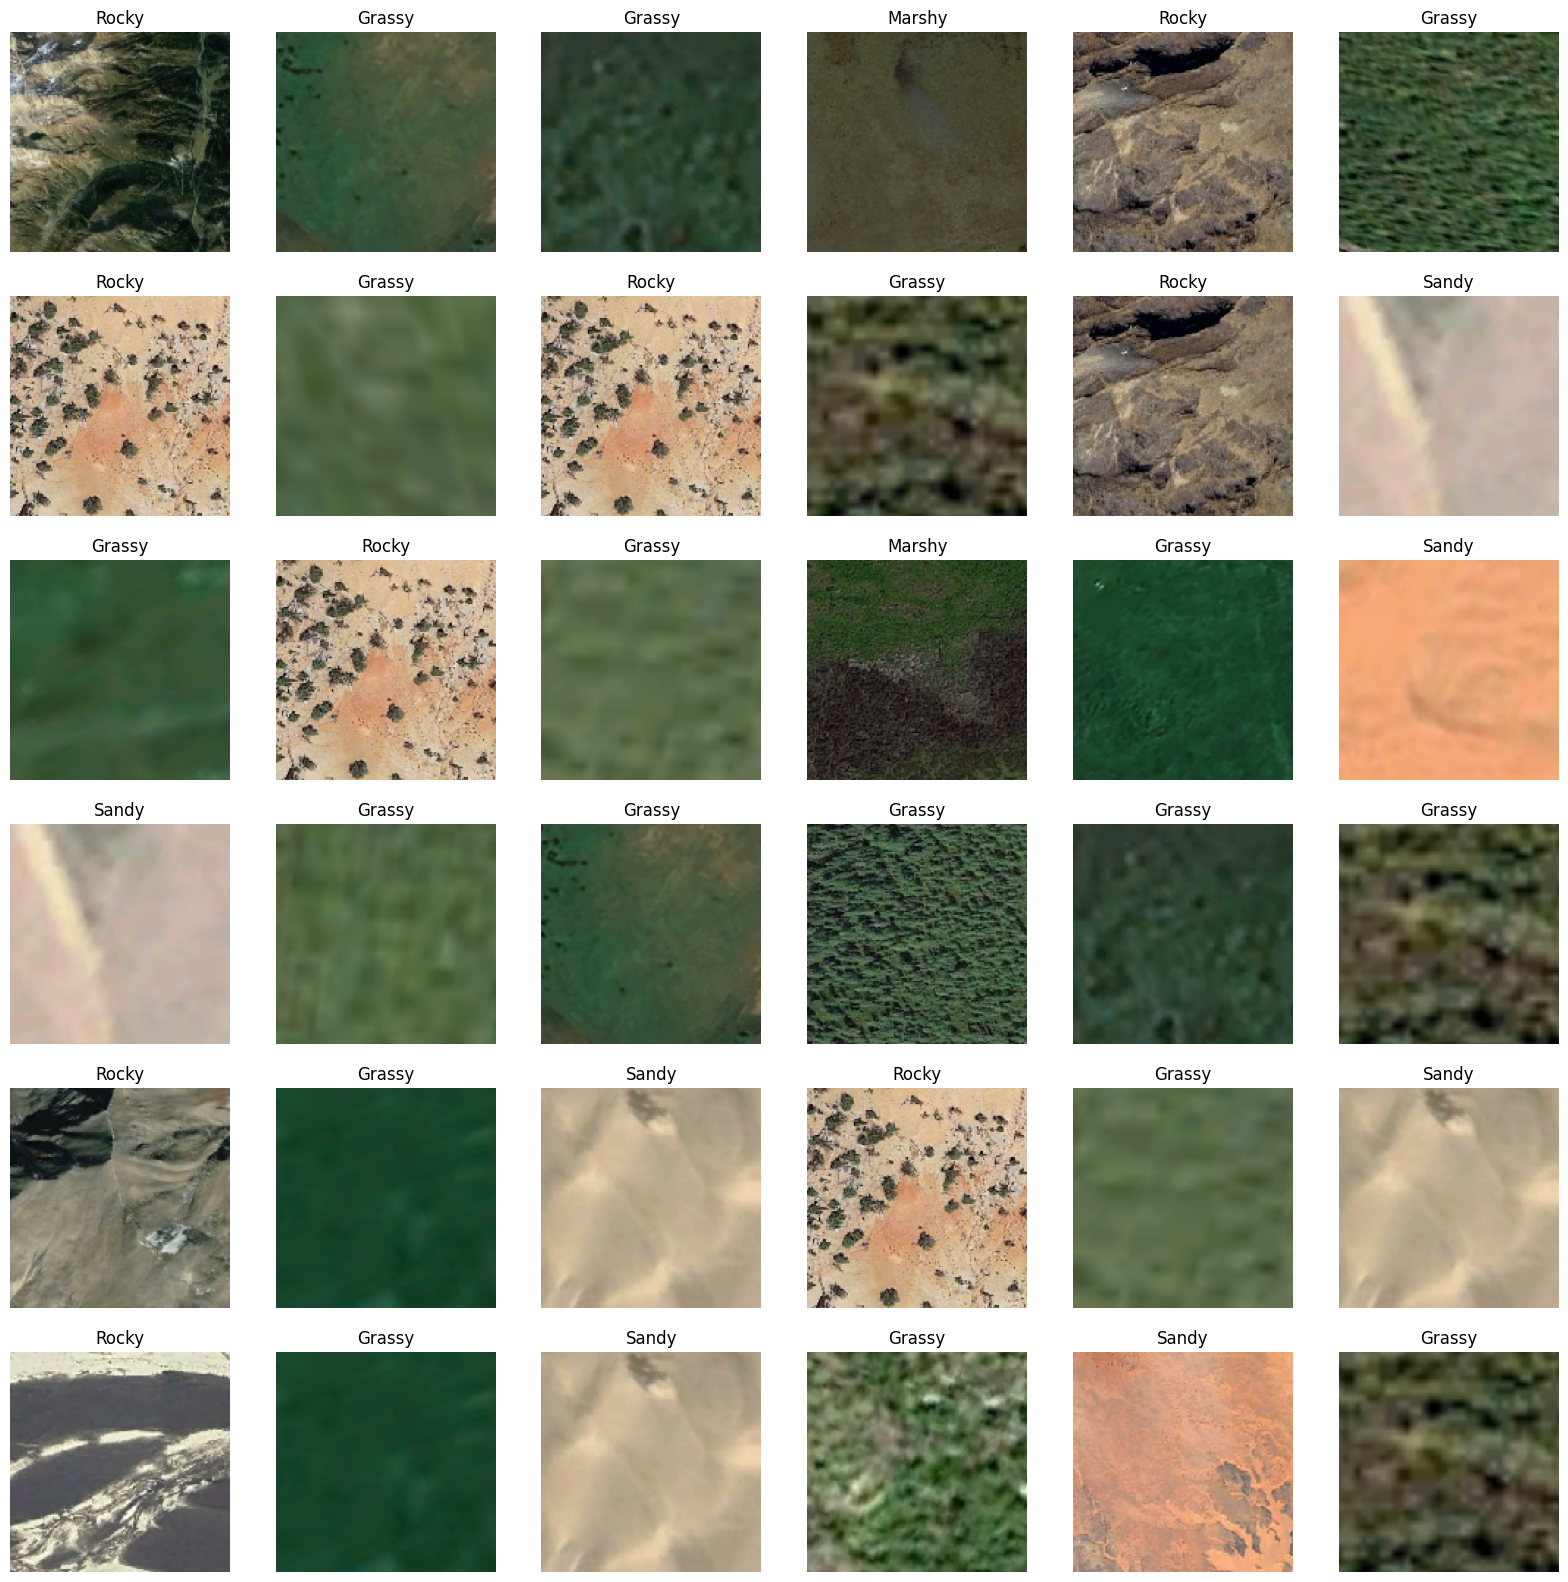

In [14]:
Show_Images(test_generator)

In [15]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(size_images, size_images, 3))

87910968/87910968 [==============================] - 0s 0us/step


In [16]:
for layer in base_model.layers:
    layer.trainable = False

In [17]:
model = tf.keras.models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Global Average Pooling to reduce dimensions
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # Assuming 4 classes
])

In [18]:
# Data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(size_images, size_images),
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(size_images, size_images),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 31571 images belonging to 4 classes.
Found 6769 images belonging to 4 classes.


In [19]:
# Callbacks
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=5,
    restore_best_weights=True,
)

learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',
    patience=5,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

In [21]:
# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=30,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[early_stopping, learning_rate_reduce]
)


Epoch 1/30


I0000 00:00:1707244907.593832     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


986/986 [==============================] - 478s 475ms/step - loss: 0.6189 - accuracy: 0.7602 - val_loss: 0.4401 - val_accuracy: 0.8301 - lr: 0.0010
Epoch 2/30
986/986 [==============================] - 262s 266ms/step - loss: 0.4463 - accuracy: 0.8324 - val_loss: 0.3742 - val_accuracy: 0.8589 - lr: 0.0010
Epoch 3/30
986/986 [==============================] - 260s 263ms/step - loss: 0.3941 - accuracy: 0.8523 - val_loss: 0.3583 - val_accuracy: 0.8645 - lr: 0.0010
Epoch 4/30
986/986 [==============================] - 260s 264ms/step - loss: 0.3554 - accuracy: 0.8701 - val_loss: 0.3624 - val_accuracy: 0.8589 - lr: 0.0010
Epoch 5/30
986/986 [==============================] - 262s 266ms/step - loss: 0.3320 - accuracy: 0.8782 - val_loss: 0.2990 - val_accuracy: 0.8880 - lr: 0.0010
Epoch 6/30
986/986 [==============================] - 275s 279ms/step - loss: 0.3099 - accuracy: 0.8885 - val_loss: 0.2783 - val_accuracy: 0.8969 - lr: 0.0010
Epoch 7/30
986/986 [==============================] - 259

In [22]:
# Evaluate on the test dataset
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2228885442018509
Test accuracy: 0.920520007610321


In [23]:
# Plot accuracy and loss graphs
# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

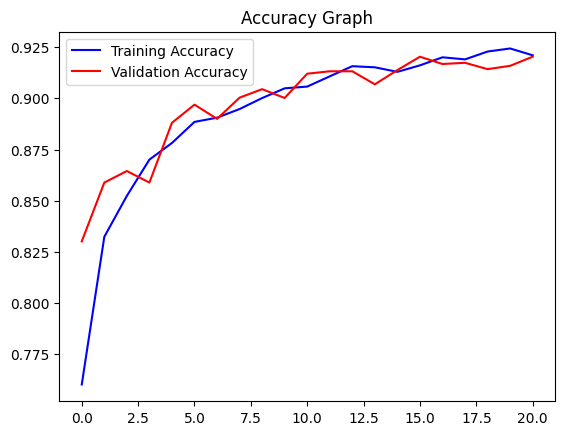

In [24]:
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show()

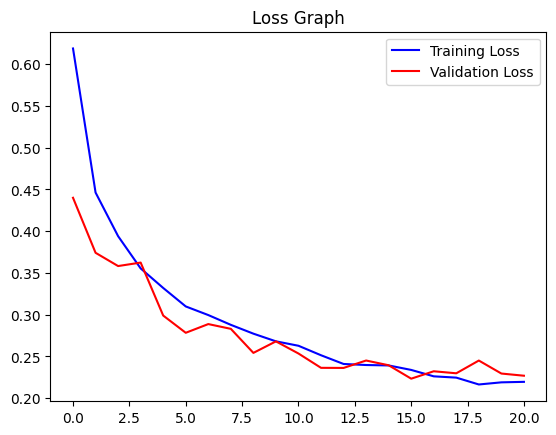

In [25]:
# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()